In [15]:
import warnings
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np

from scipy.fft import fft, ifft, fftfreq
from scipy.signal import find_peaks, convolve
from scipy import signal

from statsmodels.tsa.api import ARIMA

from fooof import FOOOF
from fooof.core.funcs import expo_function
from fooof.sim.gen import gen_aperiodic, gen_periodic

from neurodsp.sim import sim_bursty_oscillation, sim_oscillation, sim_synaptic_kernel
from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig

from timescales.sim import (sim_spikes_synaptic, sim_exp_decay, sim_acf_cos,
                            sim_branching, sim_damped_cos, sim_poisson)
from timescales.fit import ACF, compute_acf, fit_acf, fit_acf_cos, fit_psd, convert_knee_val
from timescales.optimize import fit_grid
from timescales.plts import plot_connected_scatter

### Fig. 1 Show spiking and LFP time series, and demonstrate ACF and spectral tau estimation methods

In [2]:
np.random.seed(10)

n_seconds = 100
fs = 1000
tau = convert_knee_val(10)
times = np.arange(0, n_seconds, 1/fs)

# Simulate spikes
probs, spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1, mu=100, refract=10)

# Exponentially smooth spikes
probs_est = ARIMA(spikes, order=(0, 1, 1)).fit().fittedvalues

# Simulate LFP
lfp = sim_branching(n_seconds, fs, tau, 20)
lfp = normalize_sig(lfp, 0, 1)

# Compute ACF
acf_lfp = ACF()
acf_lfp.compute_acf(lfp, fs, nlags=250)

acf_probs_est = ACF()
acf_probs_est.compute_acf(probs_est, fs, nlags=250)

corrs_lfp = acf_lfp.corrs
corrs_probs_est = acf_probs_est.corrs

corrs_lfp /= corrs_lfp.max()
corrs_probs_est /= corrs_probs_est.max()

# Compute PSD
freqs_spikes, powers_spikes = compute_spectrum(normalize_sig(probs_est, 0, 1), fs, f_range=(0, 100))
freqs_lfp, powers_lfp = compute_spectrum(normalize_sig(lfp, 0, 1), fs, f_range=(0, 100))

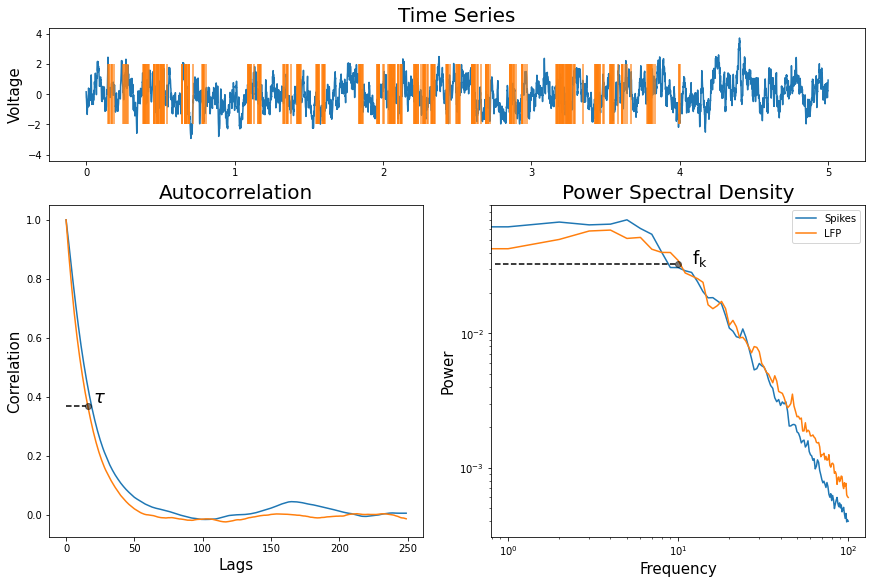

In [3]:
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
gs = GridSpec(7, 2, figure=fig)

ax0 = fig.add_subplot(gs[0:2, :])
ax1 = fig.add_subplot(gs[2:7, 0])
ax2 = fig.add_subplot(gs[2:7, 1])

# Plot LFP
_n_seconds = 5
_lfp = lfp[:int(_n_seconds * fs)]
ax0.plot(times[np.where(times < _n_seconds)[0]], _lfp, zorder=0)

# Plot Spikes
_n_seconds = 4
_times = times[np.where(spikes)[0]]
_times = _times[np.where(_times <= _n_seconds)[0] ]
ax0.eventplot(_times, color='C1', alpha=.8, lineoffsets=0, linelengths=4, zorder=1)

# Plot ACF
ax1.plot(corrs_probs_est, zorder=1)
ax1.plot(corrs_lfp, zorder=1)

# Plot PSD
ax2.loglog(freqs_spikes, powers_spikes, label='Spikes')
ax2.loglog(freqs_lfp, powers_lfp, label='LFP')
ax2.legend()

# Plot truth
ax1.scatter(convert_knee_val(10) * fs, 1/np.exp(1), zorder=2, color='k', alpha=.5)
ax1.axhline(y=1/np.exp(1), xmin=0.045, xmax=.1, ls='--', color='k')
ax1.text(20, .38, r'$\tau$', size=18)

_power = (powers_lfp[10] + powers_spikes[10])/2
ax2.scatter(10, _power, zorder=3, color='k', alpha=.5)
ax2.axhline(y=_power, xmin=.01, xmax=.5, ls='--', color='k')
ax2.text(12, _power, r'$\mathregular{f_k}$', size=18)

# Titles and labels
tsize = 20
ax0.set_title('Time Series', size=tsize)
ax1.set_title('Autocorrelation', size=tsize)
ax2.set_title('Power Spectral Density', size=tsize)

asize = 15
ax0.set_ylabel('Voltage', size=asize)
ax1.set_xlabel('Lags', size=asize)
ax1.set_ylabel('Correlation', size=asize)

ax2.set_xlabel('Frequency', size=asize)
ax2.set_ylabel('Power', size=asize);

plt.savefig('fig1_quantify.png', facecolor='w')

### Fig. 2 Show different timescales — short, long, oscillation-present, time-varying / nonstationary—to illustrate how tau estiumates can be biased when assumptions are broken

Show how ACF and spectral perform under each

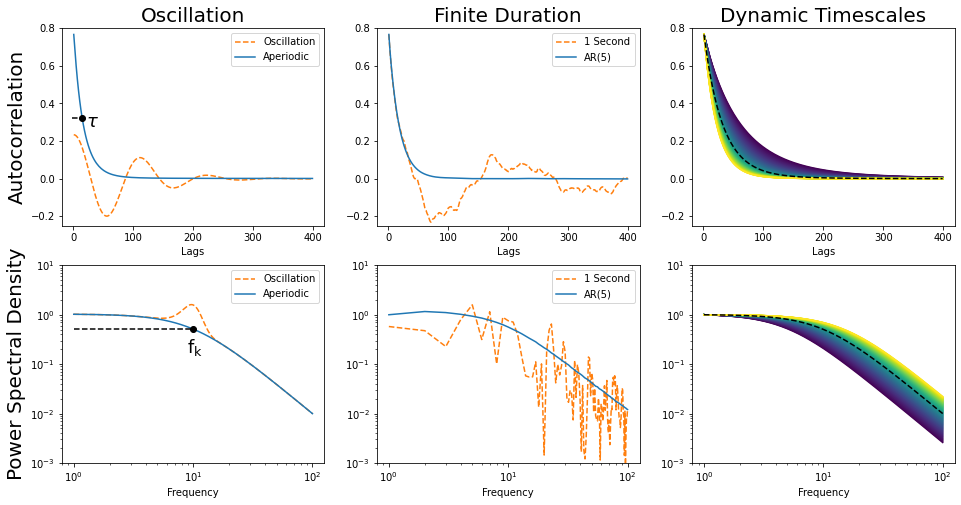

In [5]:
fig, axes = plt.subplots(figsize=(16, 8), nrows=2, ncols=3)

np.random.seed(2)

## Oscillation
fs = 1000
xs = np.arange(1, 10000)
freqs = np.linspace(1, 500, 10000)
tau = convert_knee_val(10)

# PSD
pe = gen_periodic(freqs, [10, .5, 2])
ap = gen_aperiodic(freqs, [0, 10, 2])
powers = 10**(ap + pe)
powers /= powers[0]

# Oscillations - PSD
fooof_init = {'max_n_peaks': 1}
fm, kf, tau = fit_psd(freqs, powers, f_range=(0, 100), knee_bounds=(0, 100), fooof_init=fooof_init)
ap_fit = (10**(fm._ap_fit))
knee_ind = np.argmin(np.abs(freqs-kf))

axes[1][0].loglog(fm.freqs, 10**(fm._ap_fit+fm._peak_fit), color='C1', ls='--', label='Oscillation')
axes[1][0].loglog(fm.freqs, 10**fm._ap_fit, color='C0', label='Aperiodic')

axes[1][0].scatter(freqs[knee_ind], ap_fit[knee_ind], color='k', zorder=3)
axes[1][0].axhline(ap_fit[knee_ind]-.009, 0.045, .5, color='k', ls='--')
axes[1][0].text(freqs[knee_ind]-1, ap_fit[knee_ind]-.35, r'$\mathregular{f_k}$', size=18)

# Oscillations - ACF
fm, kf, tau= fit_psd(freqs, powers, f_range=(0, 10000),
                     knee_bounds=(0, 100), fooof_init=fooof_init)

acf_ap = ifft(10**fm._ap_fit).real
acf_ap = acf_ap[:len(acf_ap)//2][:200]

acf = ifft(10**(fm.power_spectrum)).real
acf = acf[:len(acf)//2][:200]
acf_pe = acf - acf_ap

scale = 1/(acf_ap[0] + acf_pe[0])
acf_pe *= scale
acf_ap *= scale

lags = np.arange(1, 2*len(acf_ap)+1, 2)
inds = np.where(lags <= 400)
lags = lags[inds]

acf_pe = acf_pe[inds]
acf_ap = acf_ap[inds]

axes[0][0].plot(lags, acf_pe, ls='--', color='C1', label='Oscillation')
axes[0][0].plot(lags, acf_ap, color='C0', label='Aperiodic')

ind = np.argmin(np.abs(lags-int(convert_knee_val(10) * fs)))
axes[0][0].scatter(lags[ind], acf_ap[ind], color='k', zorder=4)
axes[0][0].axhline(acf_ap[ind], .04, .06, ls='--', color='k')
axes[0][0].text(lags[ind]+7, acf_ap[ind]-.05, r'$\tau$', size=18)

# Finite - ACF
sig = normalize_sig(sim_branching(1, fs, tau, 20), 0, 1)

acf = ACF()
acf.compute_acf(sig, fs)

ar = ARIMA(sig, order=(5, 0, 0)).fit()
sig_est = ar.simulate(20000000)

acf_est = ACF()
acf_est.compute_acf(sig_est, fs)

lags_f = acf.lags

corrs = (acf.corrs / acf.corrs[0]) * acf_ap[0]
corrs_est = (acf_est.corrs / acf_est.corrs[0]) * acf_ap[0]

axes[0][1].plot(lags_f[:399], corrs[:399], color='C1', ls='--', label='1 Second')
axes[0][1].plot(lags_f[:399], corrs_est[:399], color='C0', label='AR(5)')

f, p = compute_spectrum(sig, fs, f_range=(1, 100))
f_est, p_est = compute_spectrum(sig_est, fs, f_range=(1, 100))

axes[1][1].loglog(f, p/p_est[0], color='C1', ls='--', label='1 Second')
axes[1][1].loglog(f_est, p_est/p_est[0], color='C0', label='AR(5)')

# Dynamic
knees =  np.linspace(5, 15, 100)
freqs = np.linspace(1, 1000, 10000)
inds = np.where(freqs <= 100)

psds = np.array([(1/(k**2 + freqs**2)) for k in knees])

colors = plt.cm.viridis(np.linspace(0, 1, len(knees)))

for power, c in zip(psds, colors):
    
    acf = ifft(power).real[:len(power)//2]
    acf -= acf.min()
    acf /= acf.max()
    acf *= acf_ap[0]
    axes[0][2].plot(lags[:200], acf[:200], color=c)
    
    power /= power[0]
    axes[1][2].loglog(freqs[inds], power[inds], color=c)
    

power = (1/(10**2 + freqs**2))
axes[1][2].loglog(freqs[inds], power[inds]/power[0], color='k', ls='--')

acf = ifft(power).real[:len(power)//2]
acf -= acf.min()
acf /= acf.max()
acf *= acf_ap[0]

axes[0][2].plot(lags[:200], acf[:200], color='k', ls='--')


# Titles and axis labels
lsize = 10
axes[0][0].set_xlabel('Lags', size=lsize)
axes[0][1].set_xlabel('Lags', size=lsize)
axes[0][2].set_xlabel('Lags', size=lsize)
axes[1][0].set_xlabel('Frequency', size=lsize)
axes[1][1].set_xlabel('Frequency', size=lsize)
axes[1][2].set_xlabel('Frequency', size=lsize)

tsize = 20
axes[0][0].set_ylabel('Autocorrelation', size=tsize)
axes[1][0].set_ylabel('Power Spectral Density', size=tsize)

axes[0][0].set_title('Oscillation', size=tsize)
axes[0][1].set_title('Finite Duration', size=tsize);
axes[0][2].set_title('Dynamic Timescales', size=tsize);

# Y-lim
axes[0][0].set_ylim(-.25, .8)
axes[0][1].set_ylim(-.25, .8)
axes[0][2].set_ylim(-.25, .8)

axes[1][0].set_ylim(10e-4, 10e0)
axes[1][1].set_ylim(10e-4, 10e0)
axes[1][2].set_ylim(10e-4, 10e0)

# Legend
axes[0][0].legend()
axes[0][1].legend()

axes[1][0].legend()
axes[1][1].legend();

plt.savefig('fig2_bias.png', facecolor='w')

### Fig. 3 Simulation

In [3]:
np.random.seed(0)
tau = convert_knee_val(10)

n_seconds = 2
fs = 1000
kernel = sim_synaptic_kernel(10 * tau, fs, 0, tau)
mu = 200
refract = 10

# Pad n_seconds to account for convolution
kern_len = len(kernel[0]) if kernel.ndim == 2 else len(kernel)
times = np.arange(0, int(n_seconds + (kern_len * 2)), 1/fs)

# Randomly sample isi's
isi = np.round_(np.random.exponential(scale=mu, size=len(times))).astype(int)

isi = isi[np.where(isi > refract)[0]]
        
n_samples = int(n_seconds * fs)
last_ind = np.where(isi.cumsum() >= n_samples)[0]
inds = isi.cumsum() if len(last_ind) == 0 else isi[:last_ind[0]].cumsum()

poisson = np.zeros(len(times), dtype=bool)
poisson[inds] = True

# Convolve the binary poisson array with the kernel
probs = np.convolve(poisson, kernel)[:n_samples]
probs = (probs - np.min(probs)) / np.ptp(probs)

n_neurons = 1
spikes = np.zeros((n_neurons, len(probs)), dtype=bool)
for ind in range(n_neurons):
    spikes[ind] = (probs > np.random.rand(*probs.shape))
    
times = times[:n_samples]
spikes = spikes[0, :n_samples]
poisson = poisson[:n_samples]

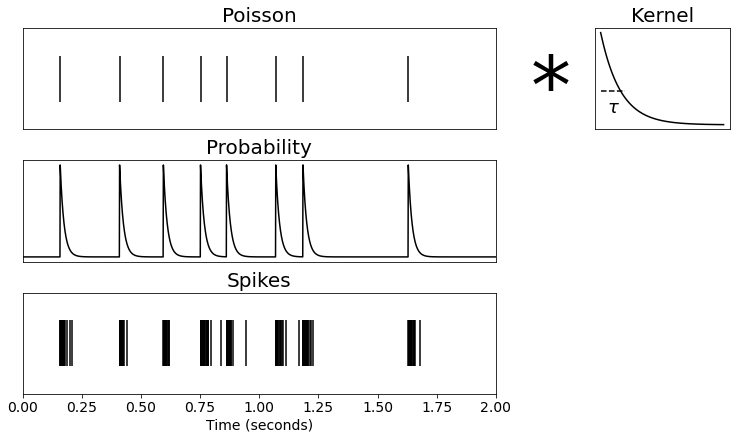

In [22]:
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = fig.add_gridspec(3, 12)

ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:8])
ax2 = fig.add_subplot(gs[0, 8:10])
ax3 = fig.add_subplot(gs[1, :7], sharex=ax0)
ax4 = fig.add_subplot(gs[2, :7], sharex=ax0)

ax0.eventplot(times[poisson], color='k')
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax0.set_title('Poisson', size=20)
ax0.set_xlim(times[poisson][0]-.1, times[poisson][-1]+.1)

ax1.text(.2, 0.15, '*', fontdict={'fontsize': 80})
ax1.axis('off')

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.plot(kernel[:100], color='k')
ax2.axhline(y=np.max(kernel)/np.exp(1), xmin=0.05, xmax=.225, ls='--', color='k')
ax2.text(5, .008, r'$\tau$', size=18)
ax2.set_title('Kernel', size=20)

ax3.plot(times, probs, color='k')
ax3.set_title('Probability', size=20)
ax3.set_yticks([])
ax3.get_xaxis().set_visible(False)

ax4.eventplot(times[spikes], color='k')
ax4.set_title('Spikes', size=20)
ax4.set_yticks([])
ax4.tick_params(axis='x', labelsize=14)
ax4.set_xlabel('Time (seconds)', size=14)

ax4.set_xlim(0, 2)

plt.savefig('fig3_simulation_a.png', dpi=125, facecolor='white')

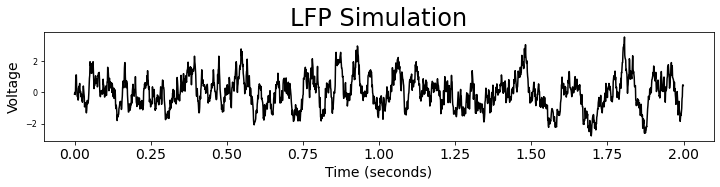

In [23]:
np.random.seed(0)

n_seconds = 2
fs = 1000
tau = convert_knee_val(10)
times = np.arange(0, n_seconds, 1/fs)

sig_branching = sim_branching(n_seconds, fs, tau, 10)
sig_branching = normalize_sig(sig_branching, 0, 1)

plt.figure(figsize=(12, 2))

plt.plot(times, sig_branching, color='k')
plt.title('LFP Simulation', size=24)
plt.xlabel('Time (seconds)', size=14)
plt.ylabel('Voltage', size=14)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=8)

plt.savefig('fig3_simulation_b.png', dpi=125, facecolor='white', bbox_inches="tight")

### Fig. 4 Bias Solutions

In [189]:
n_seconds = 100
fs = 1000
tau = convert_knee_val(10)
f_range = (0, 100)
knee_bounds = (1, 100)

niters = 100

knees_peak = np.zeros(niters)
knees_no_peak = np.zeros(niters)

for n in tqdm(range(niters)):
    
    np.random.seed(n)
    
    sig, _ = sim_spikes_synaptic(n_seconds, fs, tau)
    osc = sim_oscillation(n_seconds, fs, 20)
    
    sig = normalize_sig(sig, 0, .8)
    osc = normalize_sig(osc, 0, .2)

    sig += osc
    
    f, p = compute_spectrum(sig, fs)
    
    _, knee_peak, _ = fit_psd(f, p, f_range, knee_bounds=knee_bounds,
                              fooof_init={'max_n_peaks': 1})
    
    _, knee_no_peak, _ = fit_psd(f, p, f_range, knee_bounds=knee_bounds,
                                 fooof_init={'max_n_peaks': 0})
    knees_peak[n] = knee_peak
    knees_no_peak[n] = knee_no_peak
    
    

n_seconds = 2
knees = np.zeros(niters)
knees_ar = np.zeros(niters)
ar_orer = 2

for n in tqdm(range(niters)):
    
    fs = 1000
    tau = convert_knee_val(10)
    f_range = (0, 30)
    knee_bounds = (1, 30)

    sig, _ = sim_spikes_synaptic(n_seconds, fs, tau)
    
    f, p = compute_spectrum(sig, fs)
    
    _, knee, _ = fit_psd(f, p, f_range, knee_bounds=knee_bounds,
                         fooof_init={'max_n_peaks': 0})
    
    knees[n] = knee
    
    
    # AR(1)
    #ar = ARIMA(sig, order=(1, 0, 0)).fit()
    #ar = ar.simulate(1000000)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        ar = ARIMA(sig, order=(ar_order, 0, 0)).fit()

    # Estimate PSD
    phis = ar.params[1:-1]
    coeffs = np.append(1, -phis)
    f, p = signal.freqz(1, coeffs, fs=fs)
    p = p.real
    
    _, knee_ar, _ = fit_psd(f, p, f_range, knee_bounds=knee_bounds,
                            fooof_init={'max_n_peaks': 0})
    
    
    knees[n] = knee
    knees_ar[n] = knee_ar

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

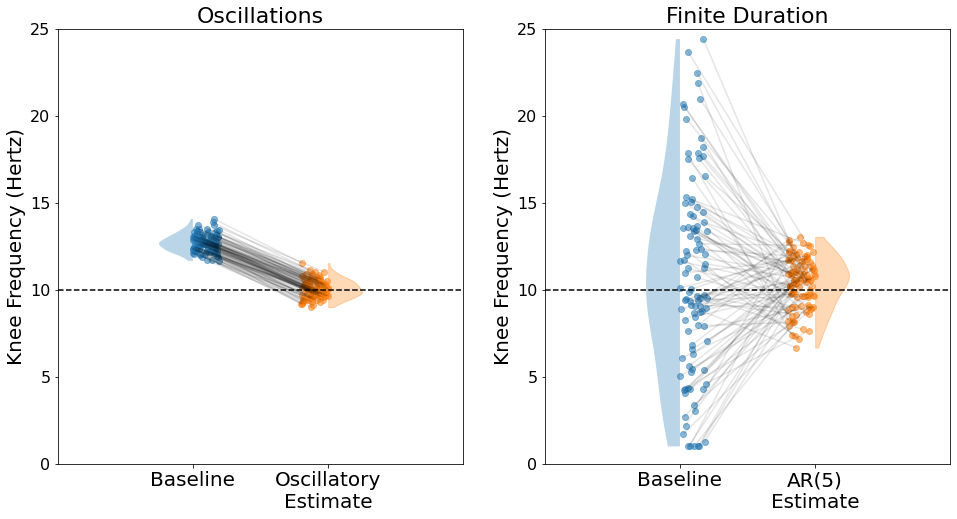

In [190]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

plot_connected_scatter(knees_no_peak, knees_peak, axes[0], title='Finite Duration',
                       xticklabels=['Baseline', 'Oscillatory\nEstimate'], ylabel='')

axes[0].axhline(10, color='k', ls='--')
axes[0].set_ylabel('Knee Frequency (Hertz)', size=20)
axes[0].set_xticklabels(['Baseline', 'Oscillatory\nEstimate'], size=20)
axes[0].set_title('Oscillations', size=22)
axes[0].set_ylim(0, 25)
axes[0].tick_params(axis='y', labelsize=16)

plot_connected_scatter(knees, knees_ar, axes[1], title='Finite Duration',
                       xticklabels=['Baseline', 'AR(5) Estimate'])

axes[1].axhline(10, color='k', ls='--')
axes[1].set_ylabel('Knee Frequency (Hertz)', size=20)
axes[1].set_xticklabels(['Baseline', 'AR(5)\nEstimate'], size=20)
axes[1].set_title('Finite Duration', size=22)
axes[1].set_ylim(0, 25)
axes[1].tick_params(axis='y', labelsize=16)

plt.savefig('fig4_bias.png', dpi=125)

### Fig 3. Bias Solution for Spikes

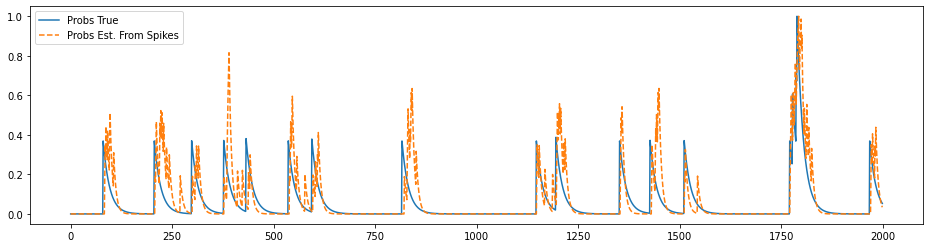

In [191]:
np.random.seed(0)

tau = convert_knee_val(10)

probs, spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1)
    
spikes_es = ARIMA(spikes, order=(0, 1, 1)).fit().fittedvalues
spikes_es /= spikes_es.max()

plt.figure(figsize=(16, 4))
plt.plot(probs, label='Probs True')
plt.plot(spikes_es, ls='--', label='Probs Est. From Spikes')

plt.legend();

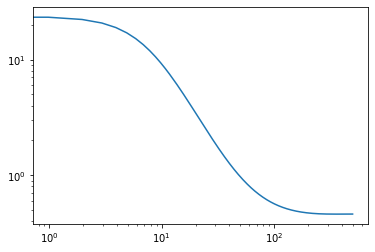

In [192]:
ar = ARIMA(spikes_es, order=(2, 0, 0)).fit()

# Estimate PSD
phis = ar.params[1:-1]
coeffs = np.append(1, -phis)
f, p = signal.freqz(1, coeffs, fs=fs)
p = p.real
plt.loglog(f, p)

In [193]:
n_seconds = 2
fs = 1000
tau = convert_knee_val(10)
f_range = (0, 100)
knee_bounds = (1, 100)

niters = 100

knees = np.zeros(niters)
knees_ar = np.zeros(niters)

for n in tqdm(range(niters)):
    
    _, spikes = sim_spikes_synaptic(n_seconds, fs, tau)
    
    spikes_es = ARIMA(spikes, order=(0, 1, 1)).fit().fittedvalues
    
    ar = ARIMA(spikes_es, order=(5, 0, 0)).fit()

    # Estimate PSD
    phis = ar.params[1:-1]
    coeffs = np.append(1, -phis)
    f, p = signal.freqz(1, coeffs, fs=fs)
    p = p.real

    _, knee_ar, _ = fit_psd(f, p, (0, 30), knee_bounds=(.1, 30))
    
    # No AR
    f, p = compute_spectrum(spikes, fs)
    _, knee, _ = fit_psd(f, p, (0, 30), knee_bounds=(.1, 30))
    
    knees[n] = knee
    
    knees_ar[n] = knee_ar

  0%|          | 0/100 [00:00<?, ?it/s]

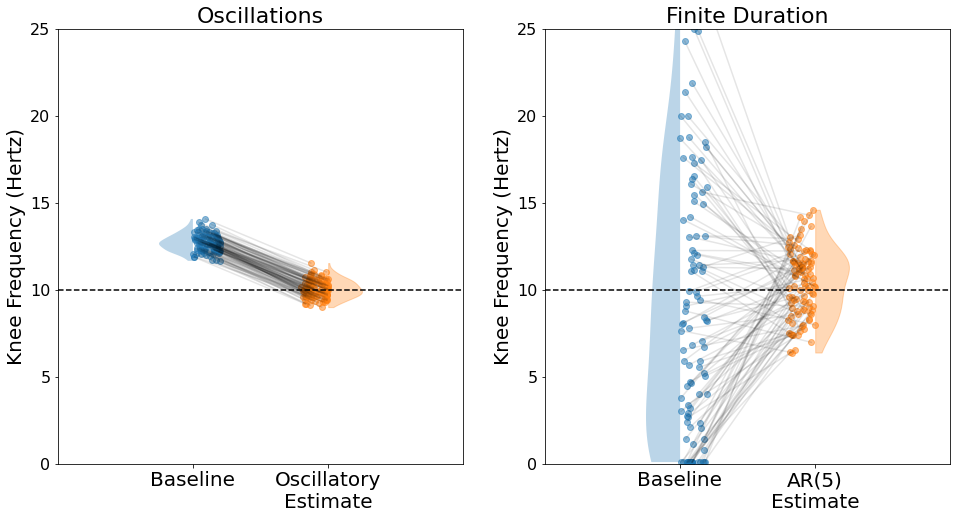

In [194]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

plot_connected_scatter(knees_no_peak, knees_peak, axes[0], title='Finite Duration',
                       xticklabels=['Baseline', 'Oscillatory\nEstimate'], ylabel='')

axes[0].axhline(10, color='k', ls='--')
axes[0].set_ylabel('Knee Frequency (Hertz)', size=20)
axes[0].set_xticklabels(['Baseline', 'Oscillatory\nEstimate'], size=20)
axes[0].set_title('Oscillations', size=22)
axes[0].set_ylim(0, 25)
axes[0].tick_params(axis='y', labelsize=16)

plot_connected_scatter(knees, knees_ar, axes[1], title='Finite Duration',
                       xticklabels=['Baseline', 'AR(5) Estimate'])

axes[1].axhline(10, color='k', ls='--')
axes[1].set_ylabel('Knee Frequency (Hertz)', size=20)
axes[1].set_xticklabels(['Baseline', 'AR(5)\nEstimate'], size=20)
axes[1].set_title('Finite Duration', size=22)
axes[1].set_ylim(0, 25)
axes[1].tick_params(axis='y', labelsize=16)

plt.savefig('fig4_bias_spikes.png', dpi=125)

### Fig. 5 Rat Results

In [40]:
import os.path as op

import numpy as np
from scipy.io import loadmat

from timescales.mp import compute_taus
from timescales.fit import convert_knee_val
from timescales.plts import plot_connected_scatter
from timescales.utils import create_windows, get_distinct_windows
from timescales.optimize import fit_grid

In [41]:
# Load LFP
data_id = '20140526_277um'
data_dir = f'/home/rph/Projects/timescale-methods/fcx1/data_mats/{data_id}'

fs = 1250

# Take mean of all hippocampal channels
channels = [*list(range(64, 68)), *list(range(76, 84)), *list(range(92, 96))]

lfp_file = op.join(data_dir, 'data01.mat')
sig_lfp = loadmat(lfp_file)['data'][0]
sig_lfp = np.zeros((len(channels), len(sig_lfp)))

for cind, ch in enumerate(channels):
    lfp_file = op.join(data_dir, f'data{ch}.mat')
    _sig_lfp = normalize_sig(loadmat(lfp_file)['data'][0], mean=0, variance=1)
    sig_lfp[cind] = _sig_lfp
del _sig_lfp

sig_lfp = np.median(sig_lfp, axis=0)
times = np.arange(0, len(sig_lfp)/fs, 1/fs)

# Extract behavioral data
beh_file = op.join(data_dir, f'{data_id}_WSRestrictedIntervals.mat')

beh = loadmat(beh_file)

nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) * fs
rem = beh['REMTimePairFormat'].astype(int) * fs

In [46]:
# Settings
win_len = int(1*fs)
win_spacing = int(1*fs)

# Remove edges to reduce edge trial edge effects
wake_pad = wake.copy()
wake_pad[:, 0] = wake_pad[:, 0] + win_len
wake_pad[:, 1] = wake_pad[:, 1] - win_len

nrem_pad = nrem.copy()
nrem_pad[:, 0] = nrem_pad[:, 0] + win_len
nrem_pad[:, 1] = nrem_pad[:, 1] - win_len

# Create spectral windows
wake_starts, wake_mids, wake_ends = create_windows(wake_pad, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem_pad, win_len, win_spacing)

# Get non-overlapping windows - for independence in stats
wake_starts_noover, wake_ends_noover = get_distinct_windows(wake_starts, wake_ends)
nrem_starts_noover, nrem_ends_noover = get_distinct_windows(nrem_starts, nrem_ends)

In [176]:
ar_order = 1

f_range = (0, 30)
knee_bounds = (.1, 30)

knees_wake = np.zeros(len(wake_starts_noover))
knees_wake_ar = np.zeros(len(wake_starts_noover))

for ind, (start, end) in enumerate(tqdm(zip(wake_starts_noover, wake_ends_noover),
                                        total=1000)):

        
    sig_win = sig_lfp[start:end]
    freqs_win, powers_win = compute_spectrum(sig_win, fs)
        

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        ar = ARIMA(sig_win, order=(ar_order, 0, 0)).fit()

        # Estimate PSD
        #phis = ar.params[1:-1]
        #coeffs = np.append(1, -phis)
        #freqs_win_ar, powers_win_ar = signal.freqz(1, coeffs, fs=fs)
        #powers_win_ar = powers_win_ar.real
        #powers_win_ar += powers_win_ar.min() + 1e-6
        sig_win_ar = ARIMA(sig_win, order=(2, 0, 0)).fit().simulate(1000000)
        freqs_win_ar, powers_win_ar = compute_spectrum(sig_win_ar, fs)
  
        _, knee, _ = fit_psd(freqs_win, powers_win, f_range, knee_bounds=knee_bounds)
        _, knee_ar, _ = fit_psd(freqs_win_ar, powers_win_ar, f_range, knee_bounds=knee_bounds)
    
    
    knees_wake[ind] = knee
    knees_wake_ar[ind] = knee_ar
    
    if ind == 1000:
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

In [177]:
f_range = (0, 100)
knee_bounds = (.1, 100)

knees_nrem = np.zeros(len(nrem_starts_noover))
knees_nrem_ar = np.zeros(len(nrem_starts_noover))

for ind, (start, end) in enumerate(tqdm(zip(nrem_starts_noover, nrem_ends_noover),
                                        total=1000)):
    
    sig_win = sig_lfp[start:end]
    freqs_win, powers_win = compute_spectrum(sig_win, fs)
    
    with warnings.catch_warnings():
        
        warnings.filterwarnings('ignore')
        
        ar = ARIMA(sig_win, order=(ar_order, 0, 0)).fit()

        # Estimate PSD
        #phis = ar.params[1:-1]
        #coeffs = np.append(1, -phis)
        #freqs_win_ar, powers_win_ar = signal.freqz(1, coeffs, fs=fs)
        #powers_win_ar = powers_win_ar.real
        #powers_win_ar += powers_win_ar.min() + 1e-6
        #sig_win_ar = ARIMA(sig_win, order=(2, 0, 0)).fit().simulate(1000000)
        #freqs_win_ar, powers_win_ar = compute_spectrum(sig_win_ar, fs)

        _, knee, _ = fit_psd(freqs_win, powers_win, f_range, knee_bounds=knee_bounds)
        _, knee_ar, _ = fit_psd(freqs_win_ar, powers_win_ar, f_range, knee_bounds=knee_bounds)
    
    
    knees_nrem[ind] = knee
    knees_nrem_ar[ind] = knee_ar
    
    if ind == 1000:
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

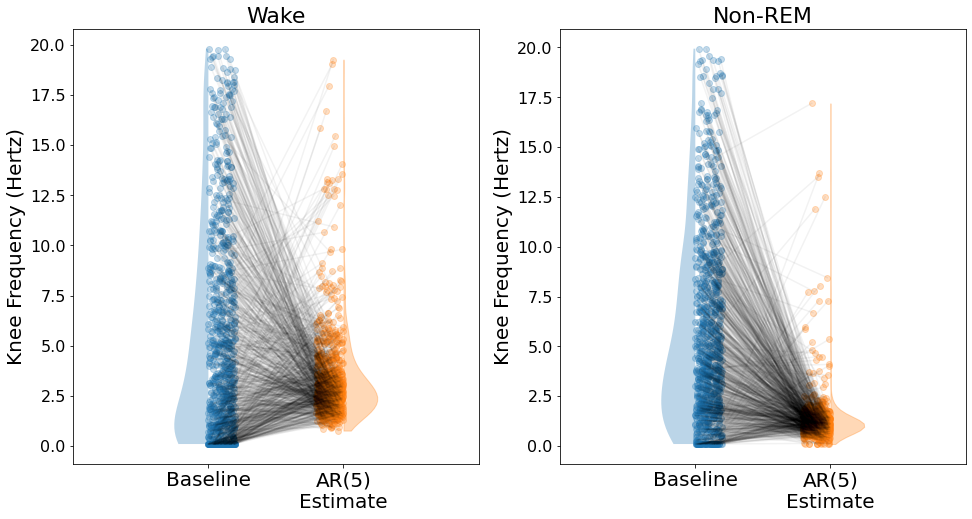

In [143]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

w_inds = np.where((knees_wake <= 20) & (knees_wake_ar <= 20) & \
                  (knees_wake > 0) & (knees_wake_ar > 0))

plot_connected_scatter(knees_wake[w_inds], knees_wake_ar[w_inds], axes[0], title='Wake',
                       xticklabels=['Baseline', 'AR(5)\nEstimate'], ylabel='',
                       alpha_scatter=.25, alpha_line=.05)

axes[0].set_ylabel('Knee Frequency (Hertz)', size=20)
axes[0].set_xticklabels(['Baseline', 'AR(5)\nEstimate'], size=20)
axes[0].set_title('Wake', size=22)

axes[0].tick_params(axis='y', labelsize=16)

n_inds = np.where((knees_nrem <= 20) & (knees_nrem_ar <= 20) & \
                  (knees_nrem > 0) & (knees_nrem_ar > 0))

plot_connected_scatter(knees_nrem[n_inds], knees_nrem_ar[n_inds], axes[1], title='Non-REM',
                       xticklabels=['Baseline', 'AR(5) Estimate'], ylabel='',
                       alpha_scatter=.25, alpha_line=.05)


axes[1].set_ylabel('Knee Frequency (Hertz)', size=20)
axes[1].set_xticklabels(['Baseline', 'AR(5)\nEstimate'], size=20)
axes[1].set_title('Non-REM', size=22)
axes[1].tick_params(axis='y', labelsize=16)


#axes[0].set_ylim(0, 20)
#axes[1].set_ylim(0, 20)
plt.savefig('fig4_rat_a.png', dpi=125)

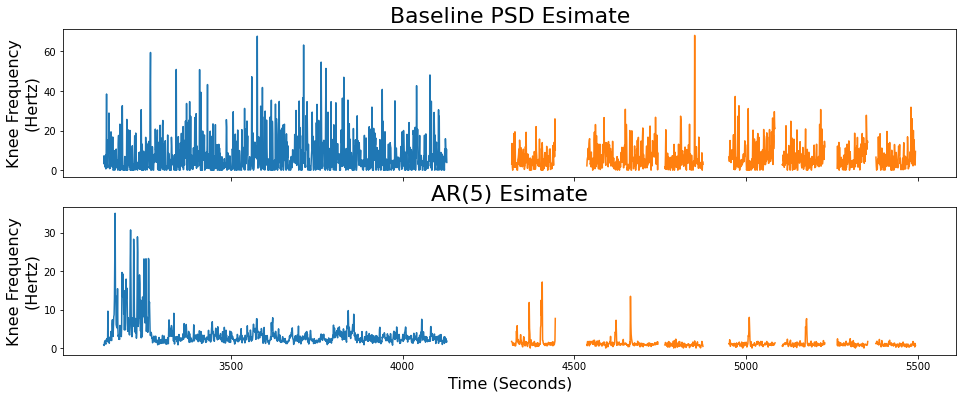

In [142]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 6), sharex=True)

# Wake
split_ind = np.where(np.diff(wake_starts_noover) != 1250)[0][0] + 1
window_mids = ((wake_starts_noover + wake_ends_noover) / 2).astype(int)

knees0_wake = knees_wake[:split_ind][:1000]
mean0_wake = knees0_wake.mean()
std0_wake = knees0_wake.std()

axes[0].plot(times[window_mids][:split_ind][:1000], knees0_wake, color='C0')

# NREM
split_ind = np.where(np.diff(nrem_starts_noover) != 1250)[0] + 1
window_mids = ((nrem_starts_noover + nrem_ends_noover) / 2).astype(int)

_ends = np.where(np.diff(nrem_starts_noover) != 1250)[0] + 1
_ends = _ends[:np.where(_ends < 1000)[0][-1]]
_starts = np.array([0, *_ends[:-1]])

for _start, _end in zip(_starts, _ends):
    
    _knees = knees_nrem[_start:_end]
    _mean = _knees.mean()
    
    axes[0].plot(times[window_mids][_start:_end], _knees, color='C1')
    
## AR
# Wake
split_ind = np.where(np.diff(wake_starts_noover) != 1250)[0][0] + 1
window_mids = ((wake_starts_noover + wake_ends_noover) / 2).astype(int)

knees0_wake = knees_wake_ar[:split_ind][:1000]
mean0_wake = knees0_wake.mean()
std0_wake = knees0_wake.std()

axes[1].plot(times[window_mids][:split_ind][:1000], knees0_wake, color='C0')

# NREM
split_ind = np.where(np.diff(nrem_starts_noover) != 1250)[0] + 1
window_mids = ((nrem_starts_noover + nrem_ends_noover) / 2).astype(int)

_ends = np.where(np.diff(nrem_starts_noover) != 1250)[0] + 1
_ends = _ends[:np.where(_ends < 1000)[0][-1]]
_starts = np.array([0, *_ends[:-1]])

for _start, _end in zip(_starts, _ends):
    
    _knees = knees_nrem_ar[_start:_end]
    _mean = _knees.mean()
    
    axes[1].plot(times[window_mids][_start:_end], _knees, color='C1')
    
    
    
axes[0].set_title('Baseline PSD Esimate', size=22)
axes[1].set_title('AR(5) Esimate', size=22)

axes[0].set_ylabel('Knee Frequency\n(Hertz)', size=16)
axes[1].set_ylabel('Knee Frequency\n(Hertz)', size=16)

axes[1].set_xlabel('Time (Seconds)', size=16)

plt.savefig('fig4_rat_b.png', dpi=125)


## Manuscript Figures - Original

### Figure 1

Timscale Methods & Applications

- Traditional ACF approach
    - Avg. ACF of population
- Related Errors
    - Bias (Bayes paper) <- need to implement
        - ~~Limits event-related application~~
        - Multiple Trials (ACF vs Spectral)
    - Oscillations
        - SpecParam
        - ACF + Cos
        
Below, each trace is a separate neuron (equivalent to a separate trial). 100 neurons/trials are simulated, each with 2s of signal, simulating an event-related design.

In [2]:
# Settings
n_seconds = 2
fs = 1000
tau = 0.025
var_noise = None
n_trials = 100 # could also be interpreted as independent neurons

# Simulate Spikes
spikes = np.zeros((n_trials, int(n_seconds * fs)))
spikes_osc = np.zeros((n_trials, int(n_seconds * fs)))

for i in range(n_trials):
    
    _probs, _spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1,
                                          mu=10, var_noise=var_noise, return_sum=False)
    
    spikes[i] = _probs
    
    # Add oscillation
    _cos = sim_oscillation(n_seconds, fs, 10, phase='max')
    _cos -= _cos.min()
    _cos /= _cos.max()
    
    spikes_osc[i] = _probs + (_cos * .25)
    spikes_osc[i] = spikes_osc[i] / np.max(spikes_osc[i])
    
# Compute ACF
corrs = compute_acf(spikes, 500)
params_acf, _, _ = fit_acf(corrs, fs)
params_acf_mean, _, _ = fit_acf(corrs.mean(axis=0), fs)

corrs_osc = compute_acf(spikes_osc, 500)
params_acf_osc, _, _ = fit_acf_cos(corrs_osc, fs)
params_acf_mean_osc, _, _ = fit_acf_cos(corrs_osc.mean(axis=0), fs)

# Fit Spectra
f_range = (1, 100)
fooof_init = {'max_n_peaks': 0}
freqs, powers = compute_spectrum(spikes, fs)
fg, knee_freq, knee_tau = fit_psd(freqs, powers, f_range, fooof_init)
fg_mean, knee_freq_mean, knee_tau_mean = fit_psd(freqs, powers, f_range, fooof_init, mode='mean')

fooof_init = {'max_n_peaks': 1}
freqs_osc, powers_osc = compute_spectrum(spikes_osc, fs)
fg_osc, knee_freq_osc, knee_tau_osc = fit_psd(freqs_osc, powers_osc, f_range, fooof_init)
fg_mean_osc, knee_freq_mean_osc, knee_tau_mean_osc = fit_psd(freqs_osc, powers_osc, f_range, fooof_init, mode='mean')

/home/rph/Projects/timescale-methods/timescales/est/psd.py:113: RuntimeWarning: invalid value encountered in double_scalars
  knee_freq = knee**(1./exponent)


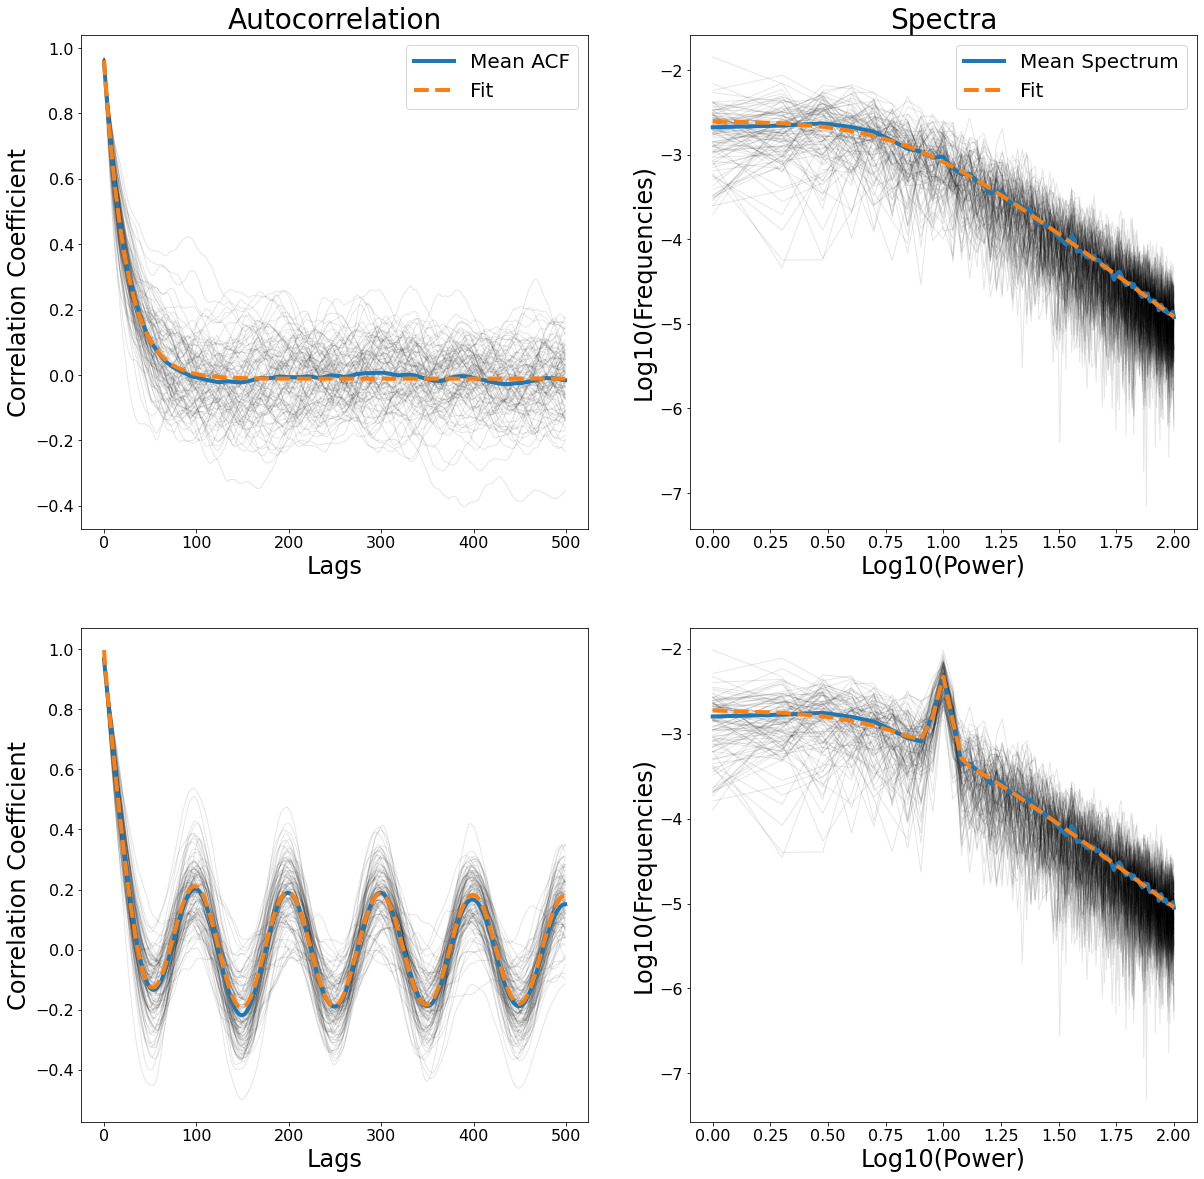

In [3]:
# Plot ACF
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))

for ind, c in enumerate(corrs):
    axes[0][0].plot(c, color='k', alpha=.1, lw=1)
for ind, c in enumerate(corrs_osc):
    axes[1][0].plot(c, color='k', alpha=.1, lw=1)
    
axes[0][0].plot(corrs.mean(axis=0), label=f'Mean ACF', lw=4)
axes[1][0].plot(corrs_osc.mean(axis=0), label=f'Mean ACF', lw=4)


axes[0][0].set_xlabel('Lags', fontsize=24)
axes[1][0].set_xlabel('Lags', fontsize=24)
axes[0][0].set_ylabel('Correlation Coefficient', fontsize=24)
axes[1][0].set_ylabel('Correlation Coefficient', fontsize=24)
     
axes[0][0].tick_params(axis='x', labelsize=16)
axes[0][1].tick_params(axis='x', labelsize=16)
axes[1][0].tick_params(axis='x', labelsize=16)
axes[1][1].tick_params(axis='x', labelsize=16)
axes[0][0].tick_params(axis='y', labelsize=16)
axes[0][1].tick_params(axis='y', labelsize=16)
axes[1][0].tick_params(axis='y', labelsize=16)
axes[1][1].tick_params(axis='y', labelsize=16)

# Plot Spectra
for p in fg.power_spectra:
    axes[0][1].plot(np.log10(fg.freqs), p, color='k', alpha=.1, lw=1)
    
for p in fg_osc.power_spectra:
    axes[1][1].plot(np.log10(fg_osc.freqs), p, color='k', alpha=.1, lw=1)
    
axes[0][1].plot(np.log10(fg.freqs), np.log10(np.mean(10**fg.power_spectra, axis=0)),
                lw=4, color='C0', label='Mean Spectrum')
axes[0][1].set_xlabel('Log10(Power)', fontsize=24)
axes[0][1].set_ylabel('Log10(Frequencies)', fontsize=24)


axes[1][1].plot(np.log10(fg_osc.freqs), np.log10(np.mean(10**fg_osc.power_spectra, axis=0)),
                lw=4, color='C0', label='Mean Spectrum')
axes[1][1].set_xlabel('Log10(Power)', fontsize=24)
axes[1][1].set_ylabel('Log10(Frequencies)', fontsize=24);

axes[0][0].set_title('Autocorrelation', fontsize=28)
axes[0][1].set_title('Spectra', fontsize=28);

# Plt fits
acf_fit = sim_exp_decay(np.arange(1, len(corrs[0])+1), fs, *params_acf_mean)
acf_cos_fit = sim_acf_cos(np.arange(1, len(corrs[0])+1), fs, *params_acf_mean_osc)

axes[0][0].plot(acf_fit, label='Fit', color='C1', lw=4, ls='--')
axes[0][1].plot(np.log10(fg_mean.freqs), fg_mean.fooofed_spectrum_, label='Fit', color='C1', lw=4, ls='--')
axes[1][0].plot(acf_cos_fit, color='C1', lw=4, ls='--')
axes[1][1].plot(np.log10(fg_mean_osc.freqs), fg_mean_osc.fooofed_spectrum_, color='C1', lw=4, ls='--')


axes[0][0].legend(fontsize=20, loc='upper right')
axes[0][1].legend(fontsize=20, loc='upper right');
plt.savefig('fig1_300dpi.png', dpi=300)
plt.savefig('fig1_125dpi.png', dpi=125)

### Figure 2

Ground Truth Simulations

- Explain the Convolution + Sampling Method
- Show that methods recapitulate ground truth

In [5]:
from neurodsp.sim import sim_synaptic_kernel

n_seconds = 2
fs = 1000
kernel = sim_synaptic_kernel(5 * tau, fs, 0, tau)
mu = 50

# Pad n_seconds to account for convolution
kern_len = len(kernel[0]) if kernel.ndim == 2 else len(kernel)
times = np.arange(0, int(n_seconds + (kern_len * 2)), 1/fs)

# Randomly sample isi's
isi = np.round_(np.random.exponential(scale=mu, size=len(times))).astype(int)

n_samples = int(n_seconds * fs)
last_ind = np.where(isi.cumsum() >= n_samples)[0]
inds = isi.cumsum() if len(last_ind) == 0 else isi[:last_ind[0]].cumsum()

poisson = np.zeros(len(times), dtype=bool)
poisson[inds] = True

# Convolve the binary poisson array with the kernel
probs = np.convolve(poisson, kernel)[:n_samples]
probs = (probs - np.min(probs)) / np.ptp(probs)

n_neurons = 1
spikes = np.zeros((n_neurons, len(probs)), dtype=bool)
for ind in range(n_neurons):
    spikes[ind] = (probs > np.random.rand(*probs.shape))
    
times = times[:n_samples]
spikes = spikes[0, :n_samples]
poisson = poisson[:n_samples]

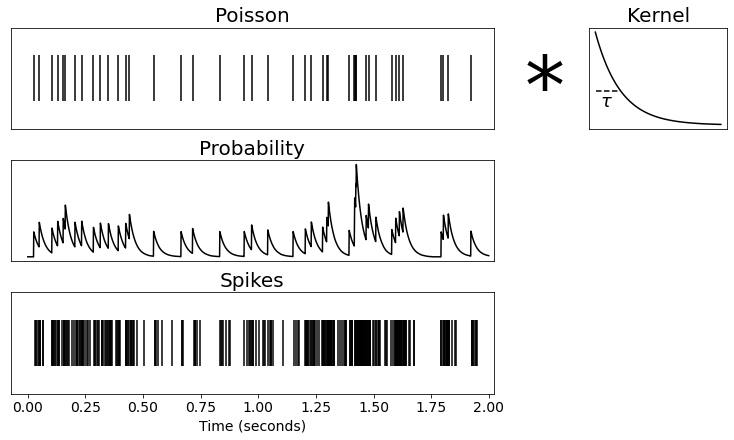

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = fig.add_gridspec(3, 12)

ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:8])
ax2 = fig.add_subplot(gs[0, 8:10])
ax3 = fig.add_subplot(gs[1, :7], sharex=ax0)
ax4 = fig.add_subplot(gs[2, :7], sharex=ax0)

ax0.eventplot(times[poisson], color='k')
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax0.set_title('Poisson', size=20)
ax0.set_xlim(times[poisson][0]-.1, times[poisson][-1]+.1)

ax1.text(.2, 0.15, '*', fontdict={'fontsize': 80})
ax1.axis('off')

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.plot(kernel, color='k')
ax2.axhline(y=np.max(kernel)/np.exp(1), xmin=0.05, xmax=.225, ls='--', color='k')
ax2.text(5, .008, r'$\tau$', size=18)
ax2.set_title('Kernel', size=20)

ax3.plot(times, probs, color='k')
ax3.set_title('Probability', size=20)
ax3.set_yticks([])
ax3.get_xaxis().set_visible(False)

ax4.eventplot(times[spikes], color='k')
ax4.set_title('Spikes', size=20)
ax4.set_yticks([])
ax4.tick_params(axis='x', labelsize=14)
ax4.set_xlabel('Time (seconds)', size=14)

plt.savefig('fig2_300dpi.png', dpi=300)
plt.savefig('fig2_125dpi.png', dpi=125)

### Figure 3

Performance of Different Methods

Function of:

- Amount of data (time & number of neurons)
- Oscillatiory Features
- Short vs Long Tau

In [7]:
from copy import deepcopy

def sim_param_grid(fs, f_range, n_iters, param_iters,
                   tau=None, mu=None, psd_bounds=None, acf_bounds=None):

    param =list(param_iters.keys())[0]
    params = param_iters[param]
    taus_acf = np.zeros((len(params), n_iters))
    taus_psd = np.zeros((len(params), n_iters))

    # Ensure f_range is iterable
    f_range = np.array(f_range)

    if f_range.ndim == 1:
        f_range = np.tile(f_range, (len(params), 1))

    acf_bounds_cos = [
        [*acf_bounds[0], None, None, None],
        [*acf_bounds[1], None, None, None]
    ]

    for ind, i in tqdm(enumerate(params), total=len(params)):


        # Determine params
        tau = tau if tau is not None else .01
        tau = i if param == 'taus' else tau

        n_seconds = 50 if param != 'n_seconds' else i

        if param == 'cos_vars':
            # Add oscillation
            _cos = sim_oscillation(n_seconds, fs, 10, phase='max')
            _cos -= _cos.min()
            _cos /= _cos.max()

        # Sample a distribution
        probs = np.zeros((n_iters, int(n_seconds * fs)))

        for j in range(n_iters):
            _probs, _ = sim_spikes_synaptic(n_seconds, fs, tau, mu=mu,
                                            n_neurons=1, return_sum=True)
            if param == 'cos_vars':
                probs[j] = _probs + (_cos * i)
            else:
                probs[j] = _probs

        # Compute ACF
        corrs = compute_acf(probs, 10000)

        if param == 'cos_vars' and i > 0:
            params, _, _ = fit_acf_cos(corrs, fs, bounds=deepcopy(acf_bounds_cos))
        else:
            params, _, _ = fit_acf(corrs, fs, bounds=deepcopy(acf_bounds))

        taus_acf[ind] = params[:, 0]

        # Compute PSD
        if param == 'cos_vars' and i > 0:
            fooof_init = {'max_n_peaks': 1}
        else:
            fooof_init = {'max_n_peaks': 0}

        freqs, powers = compute_spectrum(probs, fs, method='medfilt')

        psd_bounds = (0, 1000000) if psd_bounds is None else psd_bounds

        _, _, kf = fit_psd(freqs, powers, tuple(f_range[ind]),
                           fooof_init=fooof_init, knee_bounds=psd_bounds)
        taus_psd[ind] = kf

    return taus_acf, taus_psd


def plot_param_grid(params, taus_est_acf, taus_est_psd, tau_sim, xlabel, ylabel, ax,
                    mode='mean', title=None, xlim=None, ylim=None, plt_log=False, **plt_kwargs):
    
    if mode == 'mean':
        acf_mean = taus_est_acf.mean(axis=1)
        psd_mean = taus_est_psd.mean(axis=1)
    elif mode == 'median':
        acf_mean = np.median(taus_est_acf, axis=1)
        psd_mean = np.median(taus_est_psd, axis=1)
        
    acf_std = taus_est_acf.std(axis=1)
    psd_std = taus_est_psd.std(axis=1)
    
    if plt_log:
        ax.loglog(params, acf_mean, lw=4, color='C0', label='ACF', **plt_kwargs)
        ax.loglog(params, psd_mean, lw=4, color='C1', label='PSD', **plt_kwargs)
    else:
        ax.plot(params, acf_mean, lw=4, color='C0', label='ACF', **plt_kwargs)
        ax.plot(params, psd_mean, lw=4, color='C1', label='PSD', **plt_kwargs)
    
    ax.fill_between(params, acf_mean-acf_std, acf_mean+acf_std, alpha=.2)
    ax.fill_between(params, psd_mean-psd_std, psd_mean+psd_std, alpha=.2)
    
    if tau_sim is not None:
        ax.axhline(tau_sim, lw=4, alpha=0.8, ls='--', color='C2', label='Ground Truth')
    else:
        ax.plot(params, params, lw=4, alpha=0.8, ls='--', color='C2', label='Ground Truth')
        
    ax.tick_params(axis='both', labelsize=20)
    
    ax.set_xlabel(xlabel, size=28)
    ax.set_ylabel(ylabel, size=28)
    
    ax.legend(fontsize=24)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if title is not None:
        ax.set_title(title, fontsize=30)

In [8]:
# Settings
np.random.seed(0)
fs = 1000
n_iters = 50

knee_freqs= np.arange(1, 51)[::2]
taus = 1./(2*np.pi*knee_freqs)

f_range = np.zeros((len(taus), 2))
f_range[:, 1] = knee_freqs + 50
f_range[:, 0] = .5

acf_bounds = [
    [0.0001, None, None],
    [0.2, None, None]
]

psd_bounds = [0, 2000]

In [10]:
# Time
time_iters = {'n_seconds': np.arange(1, 101)}
taus_acf_time, taus_psd_time = sim_param_grid(fs, f_range[15], n_iters, time_iters,
                                              tau=taus[15], acf_bounds=acf_bounds, psd_bounds=psd_bounds)

  0%|          | 0/101 [00:00<?, ?it/s]

In [9]:
# Tau == time bias. This bias can be thought of as the number of convolutions per signal.
# for long taus, the number of convolutions is smaller than larger taus.

# Tau
#taus_iters = {'taus': taus}
#taus_acf, taus_psd = sim_param_grid(fs, f_range, n_iters, taus_iters, acf_bounds=acf_bounds)

  0%|          | 0/25 [00:00<?, ?it/s]

In [11]:
# Oscillation
cos_iters = {'cos_vars': np.arange(0, 10) / 10}
taus_acf_cos, taus_psd_cos = sim_param_grid(fs, f_range[15], n_iters, cos_iters, tau=taus[15],
                                            acf_bounds=acf_bounds)

  0%|          | 0/10 [00:00<?, ?it/s]

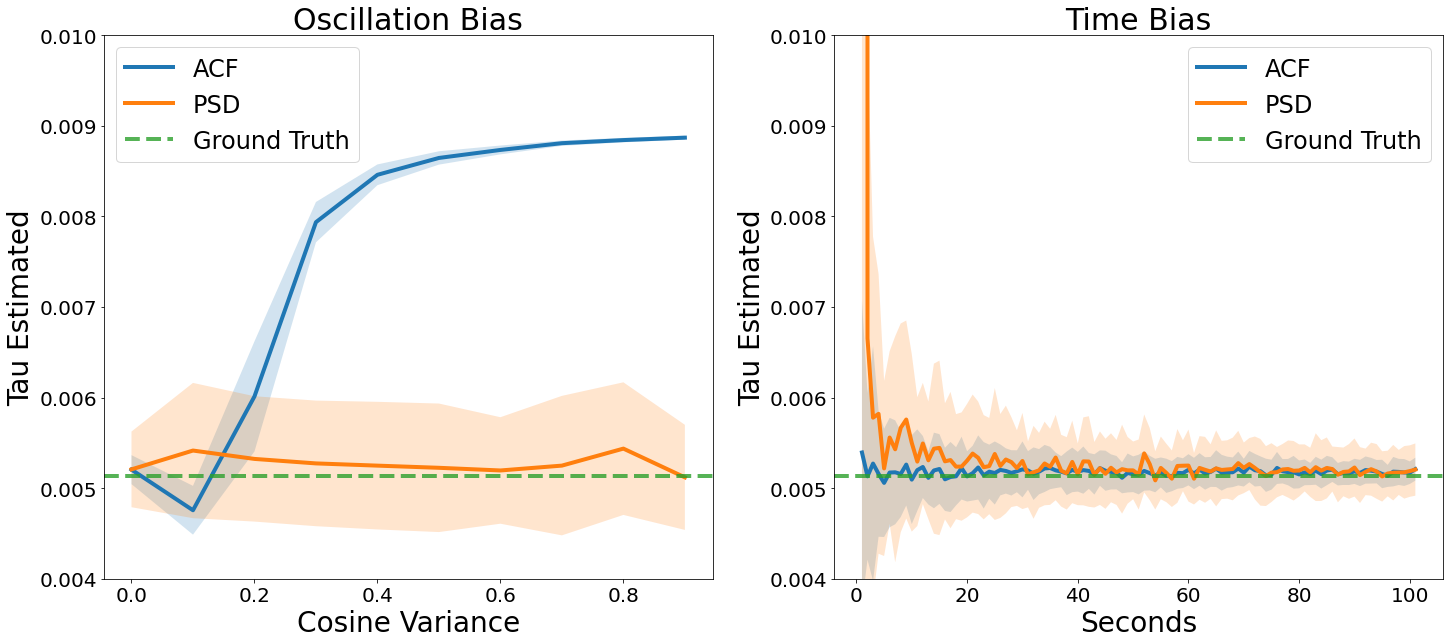

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))

plot_param_grid(cos_iters['cos_vars'], taus_acf_cos, taus_psd_cos, taus[15], 
                'Cosine Variance', 'Tau Estimated', axes[0], mode='mean',
                title='Oscillation Bias', ylim=(0.004, .01))

plot_param_grid(time_iters['n_seconds'], taus_acf_time, taus_psd_time, taus[15], 
                'Seconds', 'Tau Estimated', axes[1], mode='mean',
                title='Time Bias', ylim=(0.004, .01))

#plot_param_grid(taus_iters['taus'], taus_acf, taus_psd, None, 
#                'Tau Simulated', 'Tau Estimated', axes[2], mode='mean',
#                title='Tau Bias')

#plt.savefig('fig3.png')
plt.savefig('fig3_300dpi.png', dpi=300)
plt.savefig('fig3_125dpi.png', dpi=125)

### Figure 4

Proposed Workflow

1. Determine if oscillations are present
2. If oscillations are presence, remove them using SpecParam
    - Fit the peak removed spectrum with a knee OR
    - Convert the peak removed PSD to ACF and fit using exponential decay.
4. If oscillations are not present, use either method.

Hyper Parameters:
- Presence/Variance of oscillation
- Duration of signal
- Magnitude of tau
- PSD Method
    - Welch v Medfilt v Wavelet
- curve_fit bounds
- curve_fit guess

#### 1. Simulate

In [13]:
# Determine params
n_seconds = 50
fs = 1000

knee_freqs= np.arange(1, 51)[::2]
taus = 1./(2*np.pi*knee_freqs)
tau = taus[9] # corresponds to a 20hz knee
n_seconds = 5
n_iters = 50

_cos = sim_oscillation(n_seconds, fs, 10, phase='max')
_cos -= _cos.min()
_cos /= _cos.max()

# Sample a distribution
probs = np.zeros((n_iters, int(n_seconds * fs)))

for j in range(n_iters):
    _probs, _ = sim_spikes_synaptic(n_seconds, fs, tau,
                                    n_neurons=1, return_sum=True)

    probs[j] = _probs + (_cos * .2)

#### 2. Fit

In [14]:
freq_range=(1, 100)

freqs, powers = compute_spectrum(probs, fs, method='welch', f_range=freq_range)
_freqs, _powers = compute_spectrum(probs, fs, method='welch')

fm = FOOOF(max_n_peaks=1, aperiodic_mode='knee')
fm.fit(freqs, powers.mean(axis=0))

acf = ifft(_powers).real[:, :len(_powers[0])//2]
acf = acf / acf.max()
acf = acf[:, 1:]

inds = [
    np.where(_freqs == fm.freqs[0])[0][0],
    np.where(_freqs == fm.freqs[-1])[0][0] + 1
]

_powers_full = _powers.mean(axis=0).copy()
_powers_full[inds[0]:inds[1]] = 10**fm._spectrum_peak_rm

_corrs_peak_rm = fft(_powers_full).real
_corrs_peak_rm = _corrs_peak_rm[:len(_corrs_peak_rm)//2]
_corrs_peak_rm = _corrs_peak_rm / np.max(_corrs_peak_rm)

_corrs_ap_fit = fft(10**expo_function(_freqs, *fm.aperiodic_params_)).real
_corrs_ap_fit = _corrs_ap_fit[:len(_corrs_ap_fit)//2]
_corrs_ap_fit = _corrs_ap_fit / np.max(_corrs_ap_fit)

lags = np.arange(0, int(2 * len(_corrs_peak_rm)), 2)
lags = lags[1:101]

_corrs_peak_rm = _corrs_peak_rm[1:101]
_corrs_ap_fit = _corrs_ap_fit[1:101]

f_cos, p_cos = compute_spectrum(_cos * .2, fs)

_acf = ifft(p_cos).real[:len(p_cos)//2]
_acf = _acf / _acf.max()
_acf = _acf[1:101]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



#### 3. Plot

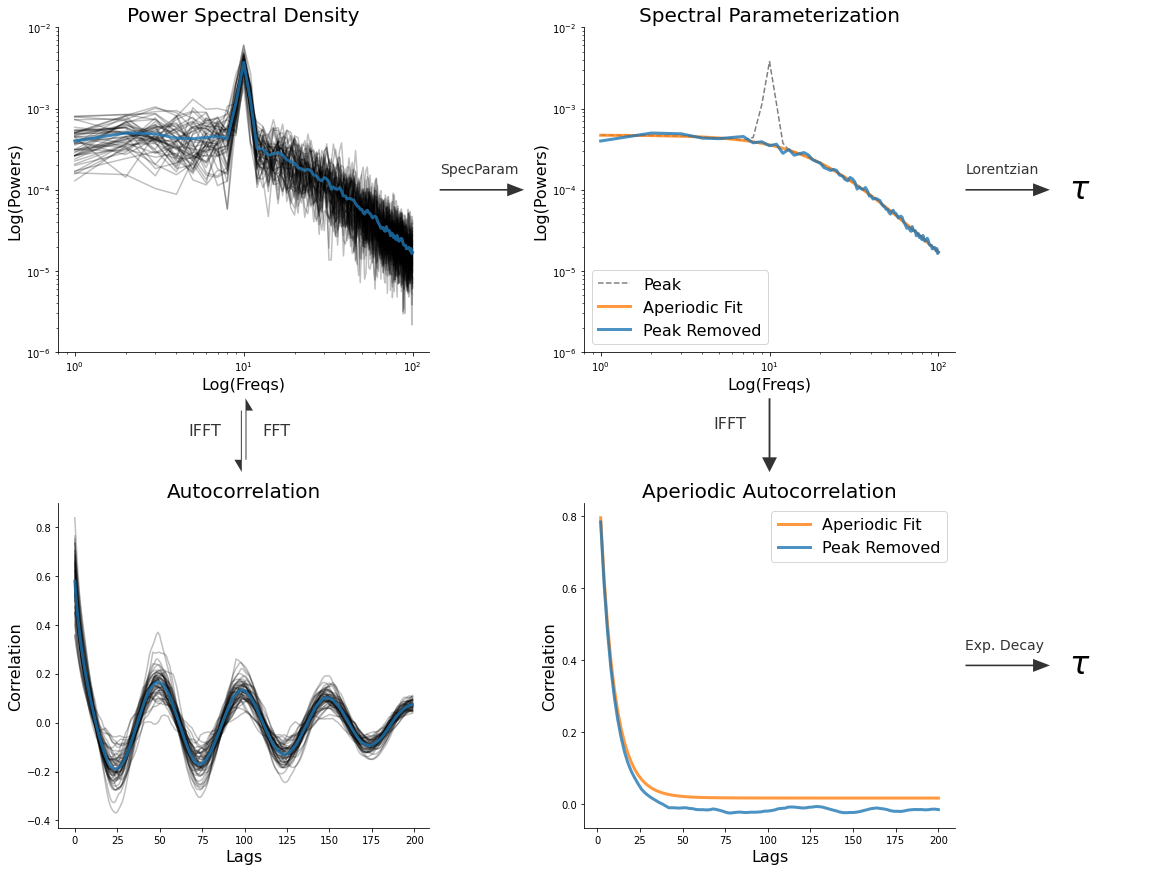

In [15]:
# Configure figure
fig = plt.figure(constrained_layout=True, figsize=(16, 12), facecolor='w')
gs = fig.add_gridspec(9, 11)

ax0 = fig.add_subplot(gs[:4, :4])    # orig spec
ax1 = fig.add_subplot(gs[:4, 4:5])   # arrow
ax2 = fig.add_subplot(gs[:4, 5:9])   # specparam fit
ax3 = fig.add_subplot(gs[:4, 9:10])  # arrow
ax4 = fig.add_subplot(gs[:4, 10:11]) # tau

ax5 = fig.add_subplot(gs[4, :4])     # psd/acf interchange arrows (orig)
ax6 = fig.add_subplot(gs[4, 5:9])    # psd/acf interchange arrows (osc rm)

ax7 = fig.add_subplot(gs[5:, :4])    # acf
ax8 = fig.add_subplot(gs[5:, 5:9])   # acf no osc
ax9 = fig.add_subplot(gs[5:, 9:10])  # arrow
ax10 = fig.add_subplot(gs[5:, 10:11])# tau

# Top Row
for p in powers:
    ax0.loglog(freqs, p, color='k', alpha=.25)
ax0.loglog(freqs, powers.mean(axis=0), lw=3, alpha=.8)
ax0.set_ylim(10**-6, 10**-2)
    
ax2.loglog(fm.freqs, 10**fm.fooofed_spectrum_, color='k', ls='--' , alpha=.5, label='Peak')
ax2.loglog(fm.freqs, 10**fm._ap_fit, label='Aperiodic Fit', color='C1', lw=3, alpha=.8)
ax2.loglog(fm.freqs, 10**fm._spectrum_peak_rm, label='Peak Removed', color='C0', lw=3, alpha=.8)
ax2.legend(fontsize=16)
ax2.set_ylim(10**-6, 10**-2)

ax4.text(.1, -.005, r'$\tau$', size=32)
ax4.set_ylim(-.1, .1)
ax4.set_xlim(0, 1)
ax4.axis('off')

# Transition arrows
arrow_alpha = .8
arrow_color = 'k'

ax1.arrow(*(0, 0), *(1, 0), width=.01, head_width=.08, head_length=.25, shape='full', lw=0,
          color=arrow_color, alpha=arrow_alpha)
ax1.text(0, .1, 'SpecParam', size=14, color=arrow_color, alpha=arrow_alpha)
ax1.set_ylim(-1, 1)
ax1.axis('off')

ax3.arrow(*(0, 0), *(1, 0), width=.01, head_width=.08, head_length=.25, shape='full', lw=0,
         color=arrow_color, alpha=arrow_alpha)
ax3.text(0, .1, 'Lorentzian', size=14, color=arrow_color, alpha=arrow_alpha)
ax3.set_ylim(-1, 1)
ax3.axis('off')

ax5.arrow(*(-.01, 1), *(0, -1), width=.01, head_width=.08, head_length=.25, shape='left', lw=0,
         color=arrow_color, alpha=arrow_alpha)
ax5.arrow(*(.01, 0), *(0, 1), width=.01, head_width=.08, head_length=.25, shape='left', lw=0,
         color=arrow_color, alpha=arrow_alpha)
ax5.text(.1, .5, 'FFT', size=16, color=arrow_color, alpha=arrow_alpha)
ax5.text(-.3, .5, 'IFFT', size=16, color=arrow_color, alpha=arrow_alpha)
ax5.set_xlim(-1, 1)
ax5.axis('off')

ax6.arrow(*(0, 1), *(0, -1), width=.01, head_width=.08, head_length=.25, shape='full', lw=0,
         color=arrow_color, alpha=arrow_alpha)
ax6.text(-.3, .5, 'IFFT', size=16, color=arrow_color, alpha=arrow_alpha)
ax6.set_xlim(-1, 1)
ax6.axis('off')

ax9.arrow(*(0, 0), *(1, 0), width=.01, head_width=.08, head_length=.25, shape='full', lw=0,
         color=arrow_color, alpha=arrow_alpha)
ax9.text(0, .1, 'Exp. Decay', size=14, color=arrow_color, alpha=arrow_alpha)
ax9.set_ylim(-1, 1)
ax9.axis('off')

# Bottom row
for a in acf:
    ax7.plot(a[:200], color='k', alpha=.25)
ax7.plot(acf.mean(axis=0)[:200], lw=3, alpha=.8)

ax8.plot(lags, _corrs_ap_fit, label='Aperiodic Fit', color='C1', lw=3, alpha=.8)
ax8.plot(lags, _corrs_peak_rm, label='Peak Removed', color='C0', lw=3, alpha=.8)
ax8.legend(fontsize=16)

ax10.text(.1, -.005, r'$\tau$', size=32)
ax10.set_ylim(-.1, .1)
ax10.set_xlim(0, 1)
ax10.axis('off')

# Axes updates
ax0.set_title('Power Spectral Density', size=20)
ax0.set_xlabel('Log(Freqs)', fontsize=16)
ax0.set_ylabel('Log(Powers)', fontsize=16)

ax2.set_title('Spectral Parameterization', size=20)
ax2.set_xlabel('Log(Freqs)', fontsize=16)
ax2.set_ylabel('Log(Powers)', fontsize=16)

ax7.set_title('Autocorrelation', size=20)
ax7.set_xlabel('Lags', fontsize=16)
ax7.set_ylabel('Correlation', fontsize=16)

ax8.set_title('Aperiodic Autocorrelation', size=20)
ax8.set_xlabel('Lags', fontsize=16)
ax8.set_ylabel('Correlation', fontsize=16)


for _ax in [ax0, ax2, ax7, ax8]:
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    _ax.yaxis.set_ticks_position('left')
    _ax.xaxis.set_ticks_position('bottom')
    
plt.savefig('fig4.png', dpi=1200)